In [1]:
import sys
sys.path.insert(0, '../')

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from typing import Tuple

from src.vg2signal import read_raw_vg_as_df, make_smoother, make_shoulder_getter, make_detilter
from src.load_dataset import load_dataset
from src.utils import tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, perform_combat_normalization

from src.generate_dataset import v2signal_extra_features

In [2]:
# Load dataset
normalization    = False
standardize_type = 'mean_std' if normalization else 'none'
split            = False
combat_norm      = False
showFileName     = True

if split:
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)

else:
    ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)

In [3]:
len(ML1_X)

130

In [12]:
# def v2signal_extra_features_our(vg_filename: str,
#              do_log: bool,
#              smoothing_bw: float,
#              vcenter: float,
#              vwidth: float,
#              stiffness: float):

#     vg_df = read_raw_vg_as_df(vg_filename)

#     if (vg_df['I'].to_numpy() < 0).any():
#         temp = [None] * 11
#         return [None, None, vg_df] + temp

#     if do_log:
#         cur_var_name = "logI"
#         #vg_df[cur_var_name] = np.emath.logn(logbase, vg_df["I"])
#         vg_df[cur_var_name] = np.log2(vg_df["I"])
#     else:
#         cur_var_name = "I"

#     smoother = make_smoother(smoothing_bw)

#     vg_df["smoothed"] = smoother(vg_df["V"], vg_df[cur_var_name].to_numpy())

#     shoulder_getter = make_shoulder_getter(1, 1.1)
#     (peak_signal, peak_v_shoulder) = shoulder_getter(vg_df["V"],
#                                                      vg_df["smoothed"])

#     vcenter = peak_v_shoulder
#     vstart = vcenter - 0.5*vwidth
#     vend = vcenter + 0.5*vwidth

#     detilter = make_detilter(vstart, vend, stiffness)
#     vg_df["detilted"] = detilter(vg_df["V"].to_numpy(),
#                                  vg_df["smoothed"].to_numpy())

   
#     return  vg_df

# def run_vg2_raw(folderpath: str, 
#             do_log:bool, 
#             recenter:bool, 
#             smoothing_bw:float, 
#             stiffness:float, 
#             vcenter:float, 
#             vwidth1:float, 
#             vwidth2:float) -> Tuple[dict, str]:

#     os.chdir(folderpath)  # change to desired folderpath
#     dfxl     = pd.DataFrame(columns=['labels', 'VI'])
    
#     for filename in os.listdir():
#         if filename[-3:] == 'txt':
#             print("Analyzing:", filename)
#             df = v2signal_extra_features(filename,
#                                         do_log,
#                                         smoothing_bw,
#                                         vcenter,
#                                         vwidth1,
#                                         stiffness)

#             idx1 = filename.rfind("cbz")
#             idx2 = filename[idx1:].find("_")
#             conc = filename[idx1 + 3:idx1 + idx2]
#             replicate = filename[idx1 + idx2 + 1:filename.rfind(".")]

#             # Crop only the signal
#             try:
#                 crop = (df['V']<1.15) & (df['V']>0.93)
#                 VI   =  df['detilted'][crop].to_numpy() 
#             except:
#                 continue

#             if 'p' in conc:  
#                 pi = conc.find('p')
#                 conctemp = conc[:pi] + '.' + conc[pi + 1:]
#                 conc = conctemp
            
#             concstrxl   = str(float(conc))
#             dfxl = pd.concat([dfxl, pd.DataFrame({'labels':concstrxl, 'VI':[VI]})])

#     with open(f"{folderpath}/raw_data.pickle", 'wb') as f:
#         dump(dfxl, f)
   
#     return    dfxl  

# def load_dataset(dataset_path=None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
#     if dataset_path==None: dataset_path = DATASET_PATH

#     if ('ML1_ML2'in os.path.basename(dataset_path)) or ('test' in os.path.basename(dataset_path)):
#         datasets = sorted([f"{i}/raw_data.pickle" for i in glob(f'{dataset_path}/*')])
        
#         df = []
#         for dataset in datasets:

#             with open(dataset, 'rb') as f:
#                 data = load(f)
#                 df.append(data) 
#         df = pd.concat(df)

#     else:
#         dataset_path = f"{dataset_path}/raw_data.pickle"
#         with open(dataset_path, 'rb') as f:
#             df = load(f)

#     X = [x.iloc[0] for (_,x) in df[['VI']].iterrows()] 
#     X = np.array(X)
#     y = df['labels'].apply(lambda x: float(x))

#     # Split the total dataset into training (60%) and testing (40%) dataset
#     X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=20, stratify=y)

#     return (X_train, X_test, y_train, y_test), (X, y)

In [5]:
ML1_X['y']        = ML1_y.apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
ML1_X['filename'] = ML1_y

ML2_X['y']        = ML2_y.apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
ML2_X['filename'] = ML2_y

ML4_X['y']        = ML4_y.apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
ML4_X['filename'] = ML4_y

In [6]:
ML1_X

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)",y,filename
0,3.9270,74.8319,1.0592,1.060,0.057938,0.0056,0.0143,1.2795,-1.4044,2.6839,1.028,1.084,0.1159,8,2024_02_19_cbz08_16.txt
1,3.1525,71.2312,1.0596,1.060,0.048110,0.0045,0.0117,1.0918,-1.2233,2.3151,1.032,1.088,0.0962,8,2024_02_19_cbz08_02.txt
2,8.3259,169.0758,1.0579,1.060,0.126038,0.0119,0.0307,2.6995,-3.0750,5.7746,1.032,1.084,0.2521,16,2024_02_19_cbz16_16.txt
3,5.1395,117.3360,1.0714,1.076,0.081811,0.0073,0.0196,1.8314,-2.1638,3.9952,1.040,1.096,0.1636,16,2024_02_19_cbz16_02.txt
4,7.1913,170.9573,1.0578,1.060,0.109513,0.0103,0.0264,2.4115,-2.5560,4.9674,1.028,1.084,0.2190,16,2024_02_19_cbz16_03.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,1.2807,83.9311,1.0003,1.000,0.015235,0.0018,0.0040,0.4498,-0.5339,0.9837,0.960,1.064,0.0305,0,2024_02_19_cbz00_43.txt
126,5.1873,117.3580,1.0561,1.056,0.076948,0.0074,0.0189,1.7284,-1.8158,3.5442,1.028,1.084,0.1539,16,2024_02_19_cbz16_27.txt
127,5.8157,126.6233,1.0605,1.060,0.084659,0.0083,0.0210,1.8284,-2.0389,3.8673,1.024,1.092,0.1693,16,2024_02_19_cbz16_33.txt
128,3.4449,79.6460,1.0552,1.056,0.050678,0.0049,0.0124,1.0982,-1.0913,2.1895,1.032,1.084,0.1014,8,2024_02_19_cbz08_27.txt


Dataset Name:  ML1
Con:8 Above_upper_bound: ['2024_02_19_cbz08_40.txt']  |  Lower_bound ['2024_02_19_cbz08_37.txt']
Con:16 Above_upper_bound: []  |  Lower_bound []
Con:0 Above_upper_bound: ['2024_02_19_cbz00_15.txt']  |  Lower_bound []


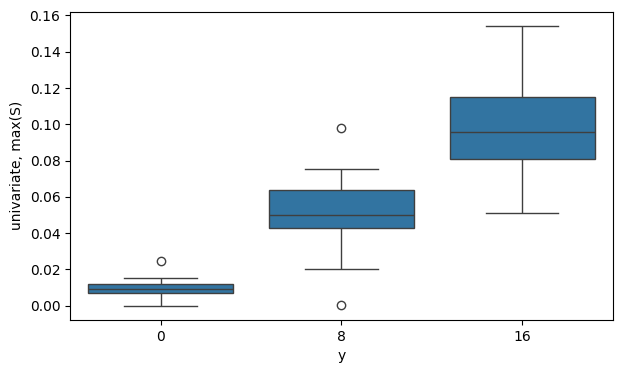


Dataset Name:  ML2
Con:0 Above_upper_bound: ['2024_02_22_cbz00_31.txt']  |  Lower_bound ['2024_02_22_cbz00_01.txt']
Con:16 Above_upper_bound: ['2024_02_22_cbz16_21.txt']  |  Lower_bound []
Con:8 Above_upper_bound: []  |  Lower_bound ['2024_02_22_cbz08_10.txt' '2024_02_22_cbz08_01.txt']


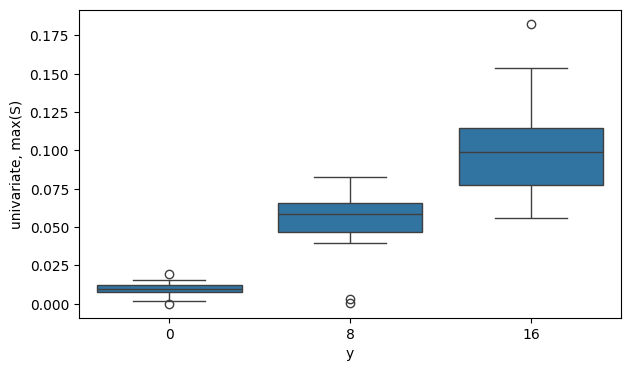


Dataset Name:  ML4
Con:8 Above_upper_bound: []  |  Lower_bound []
Con:16 Above_upper_bound: []  |  Lower_bound []
Con:0 Above_upper_bound: []  |  Lower_bound []


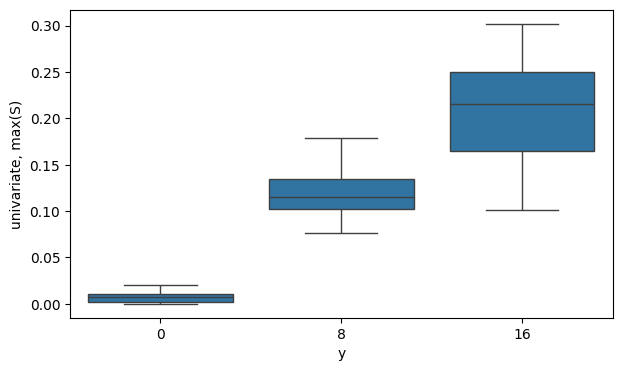

In [7]:
# data    = ML1_X.copy()
feature = 'univariate, max(S)'
# sns.boxplot(data, x='y', y=feature)

# Find outliers 
for data, name in zip([ML1_X.copy(), ML2_X.copy(), ML4_X.copy()], ['ML1', 'ML2', 'ML4']):
    print("Dataset Name: ",name)
    for i in data['y'].unique():
        Q1  = np.percentile(data[data['y']==i][feature], q=25)
        Q3  = np.percentile(data[data['y']==i][feature], q=75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
    
        above_upper_bound = data[[feature, 'filename']][(data[feature]>upper_bound) & (data['y']==i)]
        above_lower_bound = data[[feature, 'filename']][(data[feature]<lower_bound) & (data['y']==i)]

        print(f"Con:{i}", "Above_upper_bound:", above_upper_bound['filename'].values, " | ","Lower_bound",  above_lower_bound['filename'].values)
    plt.figure(figsize=(7,4))
    sns.boxplot(data, x='y', y=feature)
    plt.show()
    print()

Inside Fun 0.1826555691223799
0.1826555691223799
93    0.182656
Name: univariate, max(S), dtype: float64


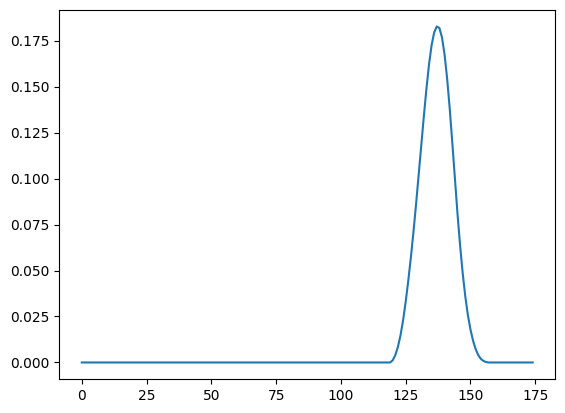

In [23]:
do_log        = True
recenter      = False
smoothing_bw  = 0.006
stiffness     = 0
vcenter       = 1.04
vwidth1       = 0.15


file     = '2024_02_22_cbz16_21.txt'
filename = f'/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2/{file}'

(peak_signal, peak_curvature, peak_v, df, vcenter, ph, signal_mean, signal_std,\
                dS_dV_max_peak, dS_dV_min_peak, dS_dV_peak_diff, dS_dV_max_V, \
                dS_dV_min_V, dS_dV_area) = v2signal_extra_features(filename,
                                                                    do_log,
                                                                    smoothing_bw,
                                                                    vcenter,
                                                                    vwidth1,
                                                                    stiffness)

plt.plot(df['detilted'])
ymaxidx = np.argmax(df["detilted"])
print(df["detilted"][ymaxidx])
print(ML2_X[ML2_X['filename']==file][feature])